# Exploring the Essemble of Random Forests - Permutation Importances

In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from scipy.stats import gaussian_kde

import seaborn as sns
sns.set()
sns.set_style("whitegrid") 
sns.set_context("paper")

## Set up

In [2]:
results_dir = 'E:/Krish_New/Dynamic_Vegetation_Project_Storage/Random_Forest_Results_On_Super_Group_Results'
results_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/RESULTS/Random_Forest_Results_On_Super_Group_Results_new'
directory = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS/MODELLED_TRAINING_DATA'
plots_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/Thesis/Plots_For_Thesis/Chapter 3'

In [3]:
SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460']

MEAN_ANNUAL_CLIMATE_FEATURES = ['MAT', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

TOPOGRAPHIC_FEATURES = ['aspect_1s', 'twi_1s']

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + TEMP_FEATURES + SOIL_FEATURES + TOPOGRAPHIC_FEATURES

TEMPORAL_FEATURES = SEASONAL_FEATURES + PRECIP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + TEMP_FEATURES
SPATIAL_FEATURES = SOIL_FEATURES + TOPOGRAPHIC_FEATURES + MEAN_ANNUAL_CLIMATE_FEATURES

In [4]:
super_group_list = ['Desert Chenopod', 'Desert Forb', 'Desert Hummock.grass',
       'Desert Shrub', 'Desert Tree.Palm', 'Desert Tussock.grass',
       'Temp/Med Shrub', 'Temp/Med Tree.Palm', 'Temp/Med Tussock.grass',
       'Tropical/Savanna Tree.Palm', 'Tropical/Savanna Tussock.grass']

# Below is the configuration for plotting purposes
ordered_veg_list = ['Desert Forb',                 'Desert Chenopod', 'Desert Hummock.grass',
                    'Desert Tree.Palm',            'Desert Shrub',    'Desert Tussock.grass',
                    'Temp/Med Tree.Palm',          'Temp/Med Shrub',  'Temp/Med Tussock.grass',
                    'Tropical/Savanna Tree.Palm',  'Tropical/Savanna Tussock.grass']

In [5]:
# Extract the aggregated importances for each group. 
number_of_folds = 10

veg_group_agg_importances = [] 
# Loop through all vegetation groups 
for chosen_super_group in super_group_list:
    
    super_group_folder_name = '_'.join(chosen_super_group.split('/')) 
    var_path = f'{results_dir}/{super_group_folder_name}/Results/Variable_Importances'
    print(super_group_folder_name)
    variable_common_rank = dict() 
    
    # Calculate the agg variable importances 
    for f in range(number_of_folds):
        folder_num = f + 1
        per_importance = pd.read_csv(f'{var_path}/KFold_{folder_num}_RF_VariableImportance_100repeats.csv')
        per_importance = per_importance.sort_values('importances_mean', ascending = False).reset_index(drop = True)
        per_importance['rank'] = per_importance.index

        feature_track = []
        for i, row in per_importance.iterrows():
            var = row['Unnamed: 0']

            rank = row['importances_mean']
            #print(var)
            if var in variable_common_rank.keys():
                variable_common_rank[var].append(rank)
            else:
                 variable_common_rank[var] = [rank]

            feature_track.append(var)       

        features_not_found = []
        for var in FEATURES:
            if var not in feature_track:

                if var in variable_common_rank.keys():
                    variable_common_rank[var].append(0)
                else:
                    variable_common_rank[var] = [0]
                features_not_found.append(var)

        #print(f'{features_not_found} was not found in Model {f+1}')

    # Convert the data into a data frame     
    collapsed_importances = dict()
    for key, value in variable_common_rank.items():
        collapsed_importances[key] =  np.mean(value)
    collapsed_importance = pd.DataFrame.from_dict(collapsed_importances, orient = 'index')  
    collapsed_importance = collapsed_importance.sort_values(0)
    collapsed_importance['group'] = chosen_super_group
    
    # Append the dataframe to a list for future merging 
    veg_group_agg_importances.append(collapsed_importance)
    
# Concat all data into one dataframe
veg_group_agg_importances_df = pd.concat(veg_group_agg_importances) 
veg_group_agg_importances_df.to_csv(f'{results_dir}/Results_Visualisation/Aggregated_Importances_100repeats.csv')

Desert Chenopod
Desert Forb
Desert Hummock.grass
Desert Shrub
Desert Tree.Palm
Desert Tussock.grass
Temp_Med Shrub
Temp_Med Tree.Palm
Temp_Med Tussock.grass
Tropical_Savanna Tree.Palm
Tropical_Savanna Tussock.grass


In [5]:
veg_group_agg_importances_df = pd.read_csv(f'{results_dir}/Results_Visualisation/Aggregated_Importances_100repeats.csv', index_col = 0)
veg_group_agg_importances_df

,0,group
twi_1s,-7.258529e+00,Desert Chenopod
tmin_lag,-8.530325e-02,Desert Chenopod
tmax_7,0.000000e+00,Desert Chenopod
tmax_lag,0.000000e+00,Desert Chenopod
fire_severity,1.875833e-15,Desert Chenopod
...,...,...
precip_30,1.128115e+01,Tropical/Savanna Tussock.grass
precip_365,1.445509e+01,Tropical/Savanna Tussock.grass
CO2,1.686487e+01,Tropical/Savanna Tussock.grass
precip_90,6.391693e+01,Tropical/Savanna Tussock.grass


In [6]:
## Determine color code for each variable
variable_groups = {'FIRE_FEATURES': [FIRE_FEATURES, 0], # temporal
                   'TOPOGRAPHIC_FEATURES': [TOPOGRAPHIC_FEATURES, 1], # spatial
                   'SOIL_FEATURES': [SOIL_FEATURES, 2], # spatial
                   'VPD_FEATURES': [VPD_FEATURES, 2], # temporal 
                   'SEASONAL_FEATURES': [SEASONAL_FEATURES, 3], # temporal
                   'TEMP_FEATURES':[TEMP_FEATURES, 1], # temporal
                   'MEAN_ANNUAL_CLIMATE_FEATURES': [MEAN_ANNUAL_CLIMATE_FEATURES, 7], # spatial
                   'CO2_FEATURES': [CO2_FEATURES, 5], 
                   'PRECIP_FEATURES': [PRECIP_FEATURES, 7]}

coloring_code = []
coloring_rbg = []


for var_name in veg_group_agg_importances_df.index:
    
    key_num = 0
    for i, v in variable_groups.items():
        #print(v[0])
        if var_name in v[0]:
            coloring_code.append(i)
            coloring_rbg.append(v[1])
        key_num += 1
    
veg_group_agg_importances_df['var_group'] = coloring_code
veg_group_agg_importances_df['color_code'] = coloring_rbg


In [14]:
# Rename some variables so they are reader-friendly 

rename_dictionary = {
    'twi_1s': 'TWI',
    'DER_000_999' : 'DER (m)',
    'aspect_1s' : 'Aspect (${\circ}$)',
    'SLGA_1' : 'SLGA (1st PC)',
    'SLGA_2' : 'SLGA (2nd PC)',
    'SLGA_3' : 'SLGA (3rd PC)', 
    'MAP' : 'MAP (mm/yr)',
    'MAT' : 'MAT (${^{\circ}C/yr)}$)',
    'CO2' : '$CO_2$ (ppm)',
    'fire_severity' : 'FS',
    'days_since_fire' : 'DSF',
    'precip_30' : 'PPT (1-30 days, mm)',
    'precip_90' : 'PPT (31-90 days, mm)',
    'precip_180' : 'PPT (91-180 days, mm)',
    'precip_365' : 'PPT (181-365 days, mm)',
    'precip_730' : 'PPT (366-730 days, mm)',
    'precip_1095' : 'PPT (731-1095 days, mm)',
    'precip_1460' : 'PPT (1096-1460 days, mm)',
    'tmin_lag' : 'Tmin (1 day, $^{\circ}C$)',
    'tmin_7' : 'Tmin (2-7 days, $^{\circ}C$)',
    'tmin_14' : 'Tmin (8-14 days, $^{\circ}C$)',
    'tmin_30' : 'Tmin (15-30 days, $^{\circ}C$)',
    'tmax_lag' : 'Tmax (1 day, $^{\circ}C$)',
    'tmax_7' : 'Tmax (2-7 days, $^{\circ}C$)',
    'tmax_14' : 'Tmax (8-14 days, $^{\circ}C$)',
    'tmax_30' : 'Tmax (15-30 days, $^{\circ}C$)',
    'VPD_lag' : 'Tmax (1 day,  kPa)',
    'VPD_7' : 'Tmax (2-7 days,  kPa)',
    'VPD_14' : 'Tmax (8-14 days,  kPa)',
    'VPD_30' : 'Tmax (15-30 days,  kPa)',
    'photoperiod' : '$\Delta$PP (hrs)',
    'photoperiod_gradient' : 'PP (1 day prior, hrs)'
} 


rename_dictionary = {
    'twi_1s': 'TWI',
    'DER_000_999' : 'DoR',
    'aspect_1s' : 'Aspect',
    'SLGA_1' : 'SLGA (PC1)',
    'SLGA_2' : 'SLGA (PC2)',
    'SLGA_3' : 'SLGA (PC3)', 
    'MAP' : 'MAP',
    'MAT' : 'MAT',
    'CO2' : '$CO_2$',
    'fire_severity' : 'FS',
    'days_since_fire' : 'DSF',
    'precip_30' : 'PPT (1-30)',
    'precip_90' : 'PPT (31-90)',
    'precip_180' : 'PPT (91-180)',
    'precip_365' : 'PPT (181-365)',
    'precip_730' : 'PPT (366-730)',
    'precip_1095' : 'PPT (731-1095)',
    'precip_1460' : 'PPT (1096-1460)',
    'tmin_lag' : 'Tmin (1)',
    'tmin_7' : 'Tmin (2-7)',
    'tmin_14' : 'Tmin (8-14)',
    'tmin_30' : 'Tmin (15-30)',
    'tmax_lag' : 'Tmax (1)',
    'tmax_7' : 'Tmax (2-7)',
    'tmax_14' : 'Tmax (8-14)',
    'tmax_30' : 'Tmax (15-30)',
    'VPD_lag' : 'VPD (1)',
    'VPD_7' : 'VPD (2-7)',
    'VPD_14' : 'VPD (8-14)',
    'VPD_30' : 'VPD (15-30)',
    'photoperiod' : 'PP',
    'photoperiod_gradient' : '$\Delta$PP'
} 

veg_group_agg_importances_df['replace_name'] = veg_group_agg_importances_df.index

name_replacement = []
for var_name in np.unique(veg_group_agg_importances_df['replace_name']):
    for i, v in rename_dictionary.items():
        if var_name == i:
            veg_group_agg_importances_df.loc[veg_group_agg_importances_df['replace_name'] == var_name, 'replace_name'] = v

In [15]:
color_pallete = list(sns.color_palette("husl", 10))

In [16]:
veg_group_agg_importances_df

,0,group,var_group,color_code,replace_name
twi_1s,-7.258529e+00,Desert Chenopod,TOPOGRAPHIC_FEATURES,1,TWI
tmin_lag,-8.530325e-02,Desert Chenopod,TEMP_FEATURES,1,Tmin (1)
tmax_7,0.000000e+00,Desert Chenopod,TEMP_FEATURES,1,Tmax (2-7)
tmax_lag,0.000000e+00,Desert Chenopod,TEMP_FEATURES,1,Tmax (1)
fire_severity,1.875833e-15,Desert Chenopod,FIRE_FEATURES,0,FS
...,...,...,...,...,...
precip_30,1.128115e+01,Tropical/Savanna Tussock.grass,PRECIP_FEATURES,7,PPT (1-30)
precip_365,1.445509e+01,Tropical/Savanna Tussock.grass,PRECIP_FEATURES,7,PPT (181-365)
CO2,1.686487e+01,Tropical/Savanna Tussock.grass,CO2_FEATURES,5,$CO_2$
precip_90,6.391693e+01,Tropical/Savanna Tussock.grass,PRECIP_FEATURES,7,PPT (31-90)


## Spatial

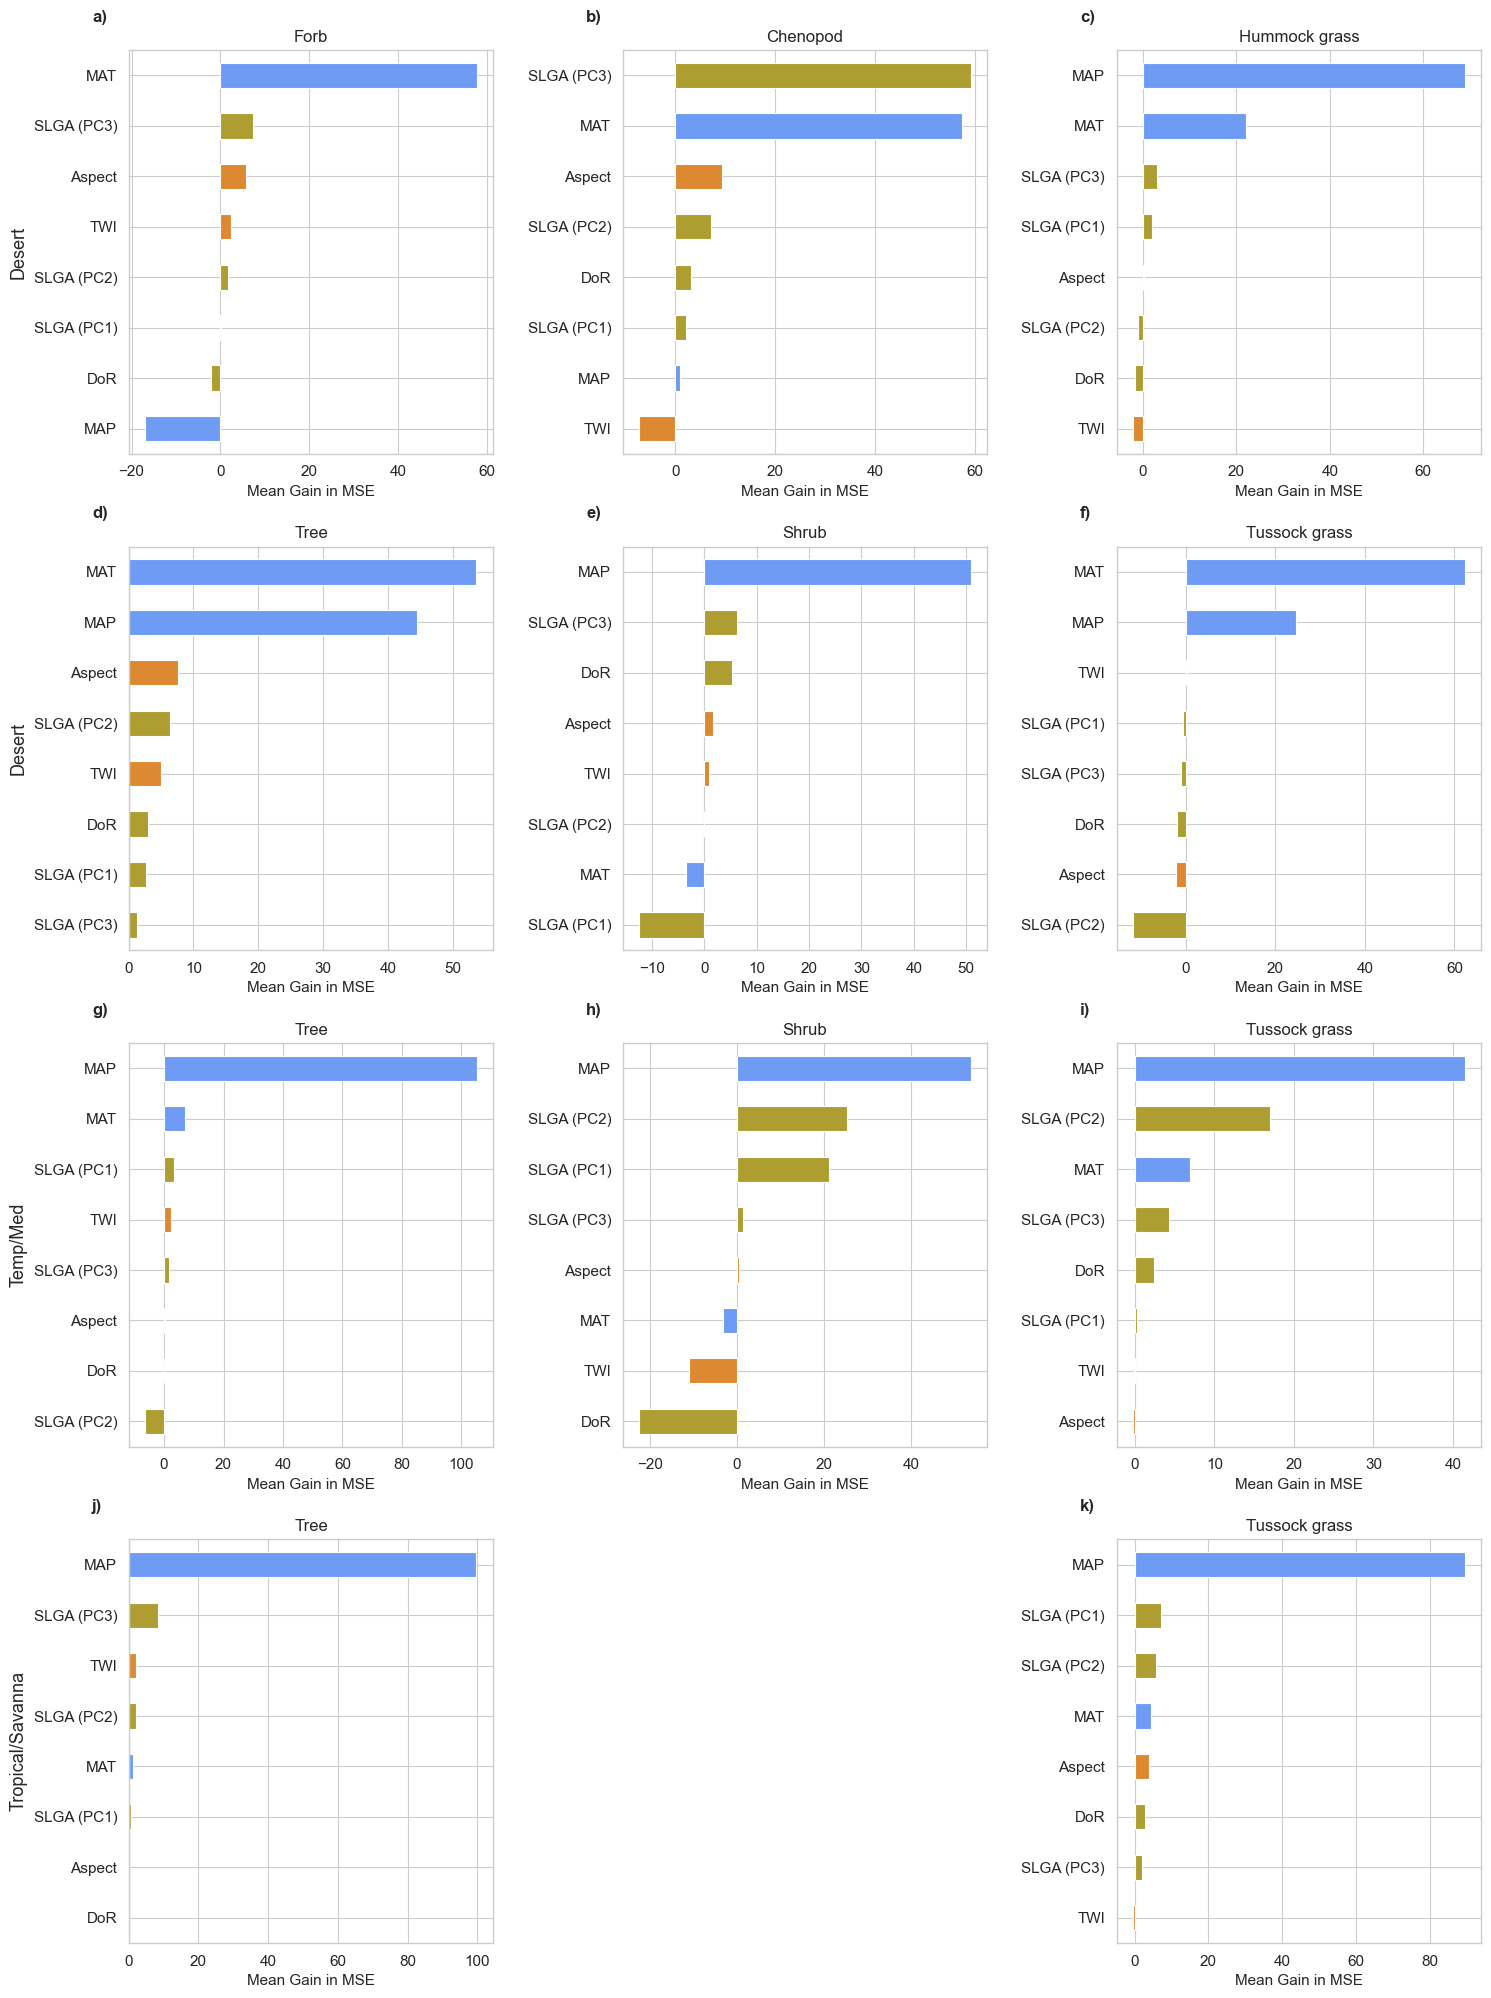

In [17]:
## Spatial features

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']

veg_group_agg_spatial = veg_group_agg_importances_df.iloc[veg_group_agg_importances_df.index.isin(SPATIAL_FEATURES)].set_index('replace_name')

for i, ax in enumerate(axes.flat):
    
    # Skip at the bottom middle grid
    if i == 10:
        ax.axis('off') 
        continue
    
    if i == 11:
        chosen_group = ordered_veg_list[10] # Since there will be a skip on the 11th cell, move the 11th veg type to the 12th grid 
    else:
        chosen_group = ordered_veg_list[i]

    veg_group_agg_spatial_group = veg_group_agg_spatial.loc[veg_group_agg_spatial['group'] == chosen_group]
    color_codes = [color_pallete[x] for x in veg_group_agg_spatial_group['color_code']]
    veg_group_agg_spatial_group['0'].plot.barh(ax = ax, color =  color_codes)
    
    # Annotation
    ax.text(-0.1, 1.1, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    # Title
    veg_name = ' '.join(chosen_group.split(" ")[1].split('.'))
    if veg_name == 'Tree Palm':
        veg_name = 'Tree'
    ax.set_title(f'{veg_name}', fontsize = 12)
    
    # Axis lables 
    if i % 3 == 0:
        ax.set_ylabel(f'{chosen_group.split(" ")[0]}', fontsize = 13)
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel('Mean Gain in MSE', fontsize = 11)
    
    ax.tick_params(axis='x', labelsize=11) 
    ax.tick_params(axis='y', labelsize=11) 

plt.tight_layout()
fig.savefig(f'{plots_dir}/Total_Individual_Model_Importances_Spatial_v2.png', bbox_inches="tight")

## Temporal

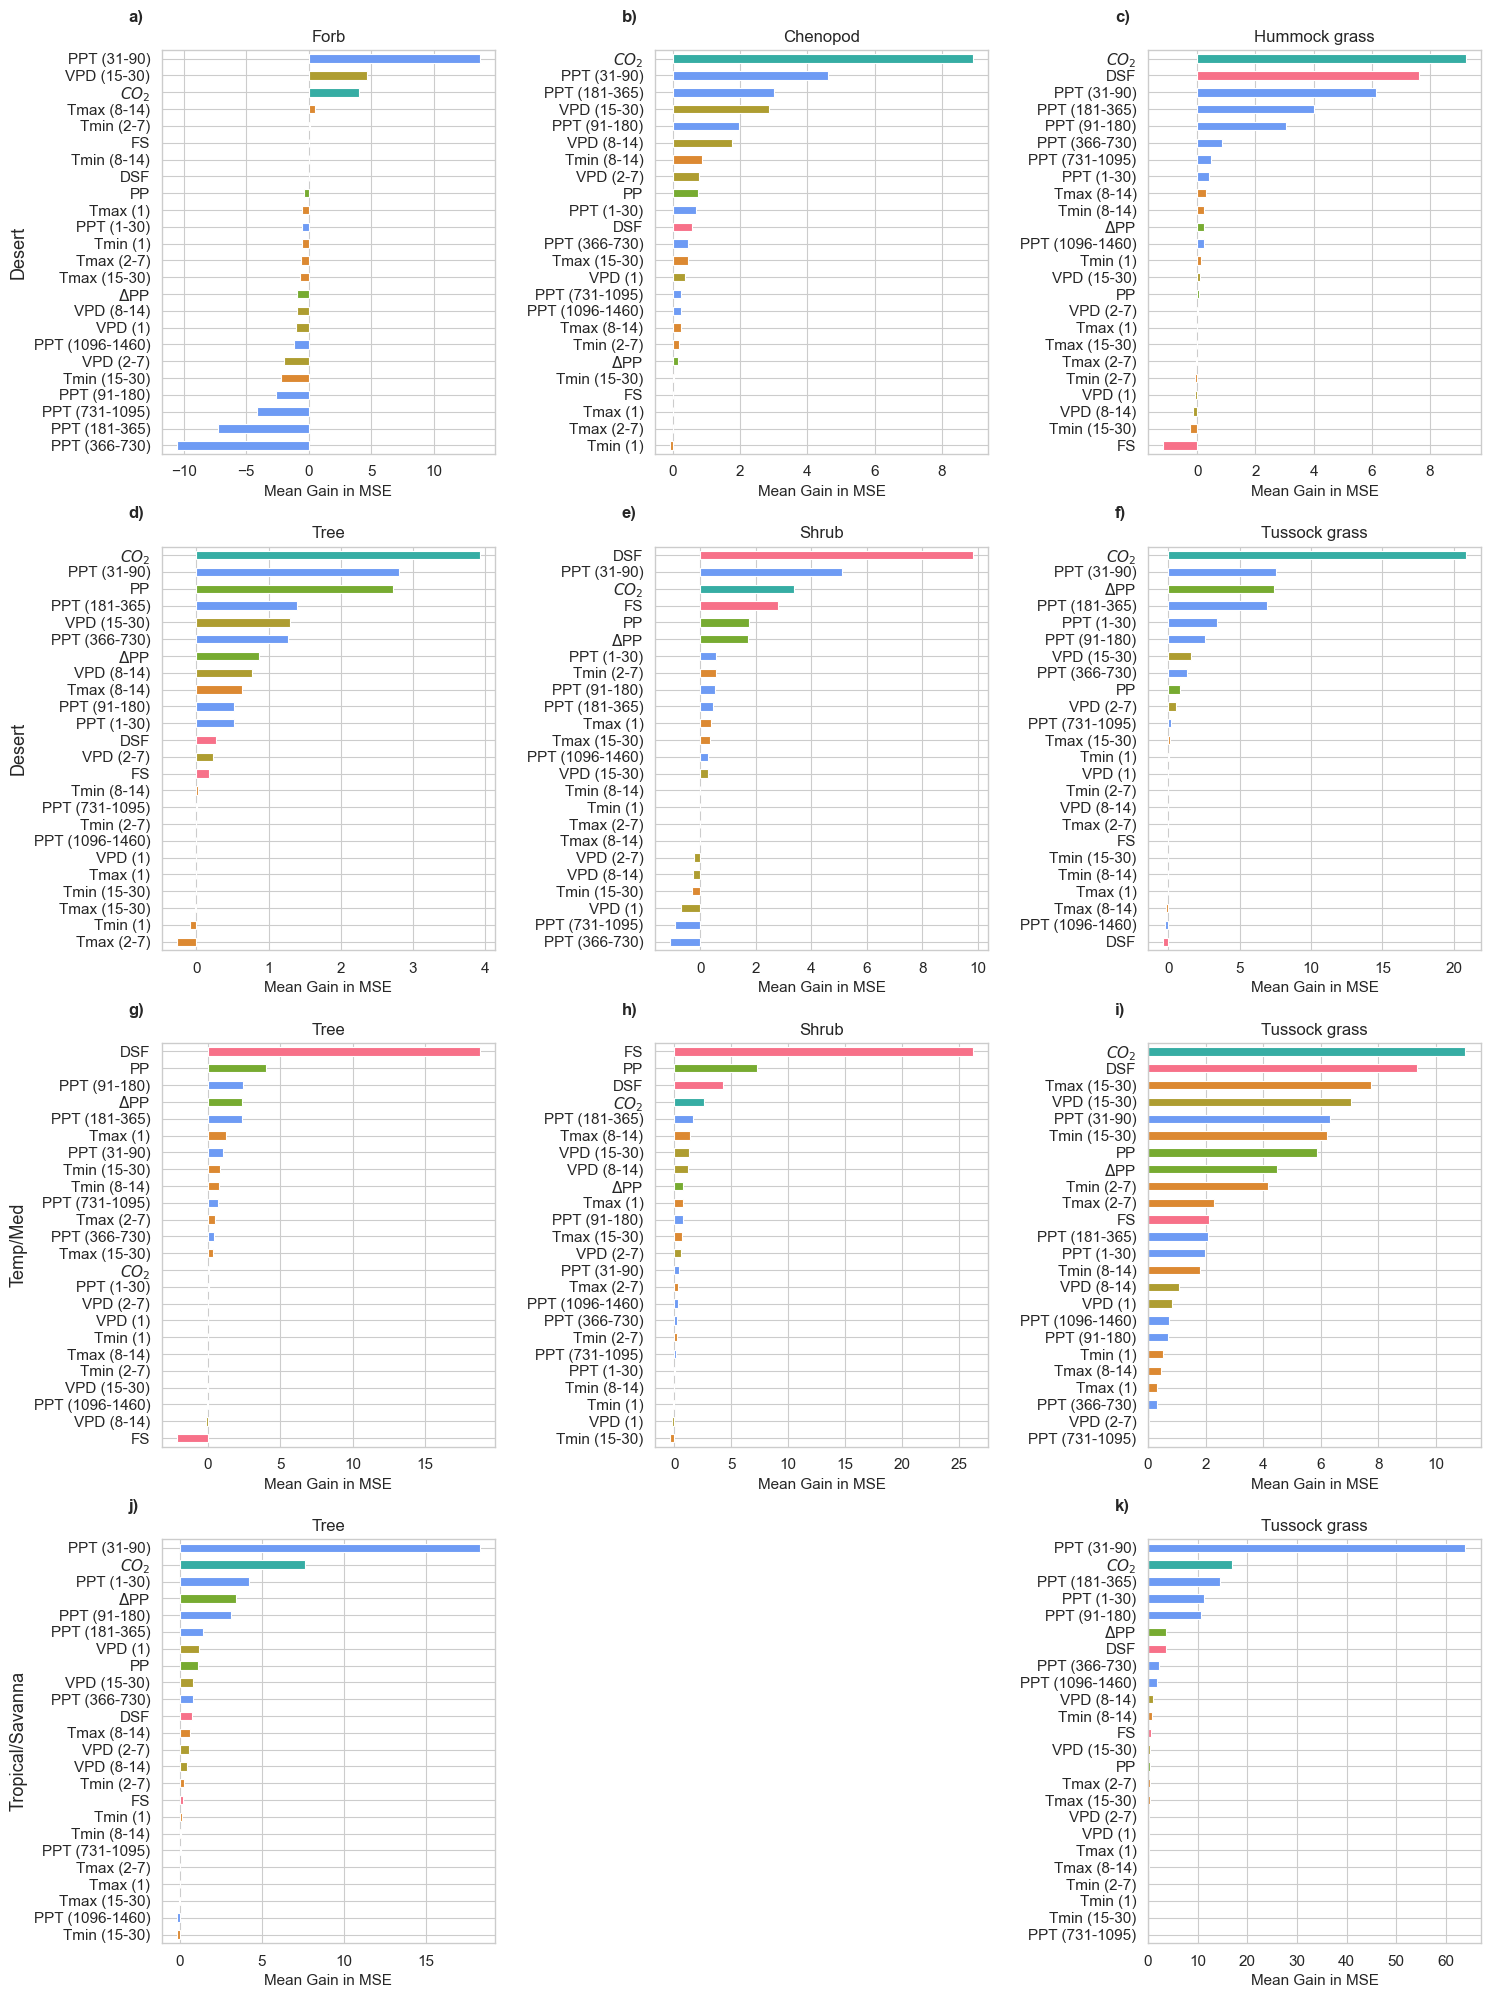

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

veg_group_agg_spatial = veg_group_agg_importances_df.iloc[veg_group_agg_importances_df.index.isin(TEMPORAL_FEATURES)].set_index('replace_name')
labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']

for i, ax in enumerate(axes.flat):
    
    # Skip at the bottom middle grid
    if i == 10:
        ax.axis('off') 
        continue
    
    if i == 11:
        chosen_group = ordered_veg_list[10] # Since there will be a skip on the 11th cell, move the 11th veg type to the 12th grid 
    else:
        chosen_group = ordered_veg_list[i]
    
    veg_group_agg_spatial_group = veg_group_agg_spatial.loc[veg_group_agg_spatial['group'] == chosen_group]
    color_codes = [color_pallete[x] for x in veg_group_agg_spatial_group['color_code']]
    veg_group_agg_spatial_group['0'].plot.barh(ax = ax, color =  color_codes)
    
    # Annotation
    ax.text(-0.1, 1.1, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    # Title
    veg_name = ' '.join(chosen_group.split(" ")[1].split('.'))
    if veg_name == 'Tree Palm':
        veg_name = 'Tree'
    ax.set_title(f'{veg_name}', fontsize = 12)
    
    
    # Axis lables 
    if i % 3 == 0:
        ax.set_ylabel(f'{chosen_group.split(" ")[0]}', fontsize = 13)
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel('Mean Gain in MSE', fontsize = 11)
    
    
    ax.tick_params(axis='x', labelsize=11) 
    ax.tick_params(axis='y', labelsize=11) 
    

        
plt.tight_layout()
fig.savefig(f'{plots_dir}/Total_Individual_Model_Importances_Temporal_v2.png', bbox_inches="tight")

# Seasonality Visualisation

In [7]:
results_dir = 'E:/Krish_New/Dynamic_Vegetation_Project_Storage/Random_Forest_Results_On_Super_Group_Results'
results_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/RESULTS/Random_Forest_Results_On_Super_Group_Results_new'
directory = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS/MODELLED_TRAINING_DATA'
plots_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/Thesis/Plots_For_Thesis/Chapter 3'

import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from scipy.stats import gaussian_kde

import seaborn as sns
sns.set()
sns.set_style("whitegrid") 
sns.set_context("paper")

In [8]:
super_group_list = ['Desert Chenopod', 'Desert Forb', 'Desert Hummock.grass',
       'Desert Shrub', 'Desert Tree.Palm', 'Desert Tussock.grass',
       'Temp/Med Shrub', 'Temp/Med Tree.Palm', 'Temp/Med Tussock.grass',
       'Tropical/Savanna Tree.Palm', 'Tropical/Savanna Tussock.grass']

# Below is the configuration for plotting purposes
ordered_veg_list = ['Desert Forb',                 'Desert Chenopod', 'Desert Hummock.grass',
                    'Desert Tree.Palm',            'Desert Shrub',    'Desert Tussock.grass',
                    'Temp/Med Tree.Palm',          'Temp/Med Shrub',  'Temp/Med Tussock.grass',
                    'Tropical/Savanna Tree.Palm',  'Tropical/Savanna Tussock.grass']

color_palette = [list(sns.color_palette("husl", 3))[1],
list(sns.color_palette("husl", 3))[2],
list(sns.color_palette("husl", 3))[0]]

Desert Forb
Desert Chenopod
Desert Hummock.grass
Desert Tree.Palm
Desert Shrub
Desert Tussock.grass
Temp_Med Tree.Palm
Temp_Med Shrub
Temp_Med Tussock.grass
Tropical_Savanna Tree.Palm
Tropical_Savanna Tussock.grass


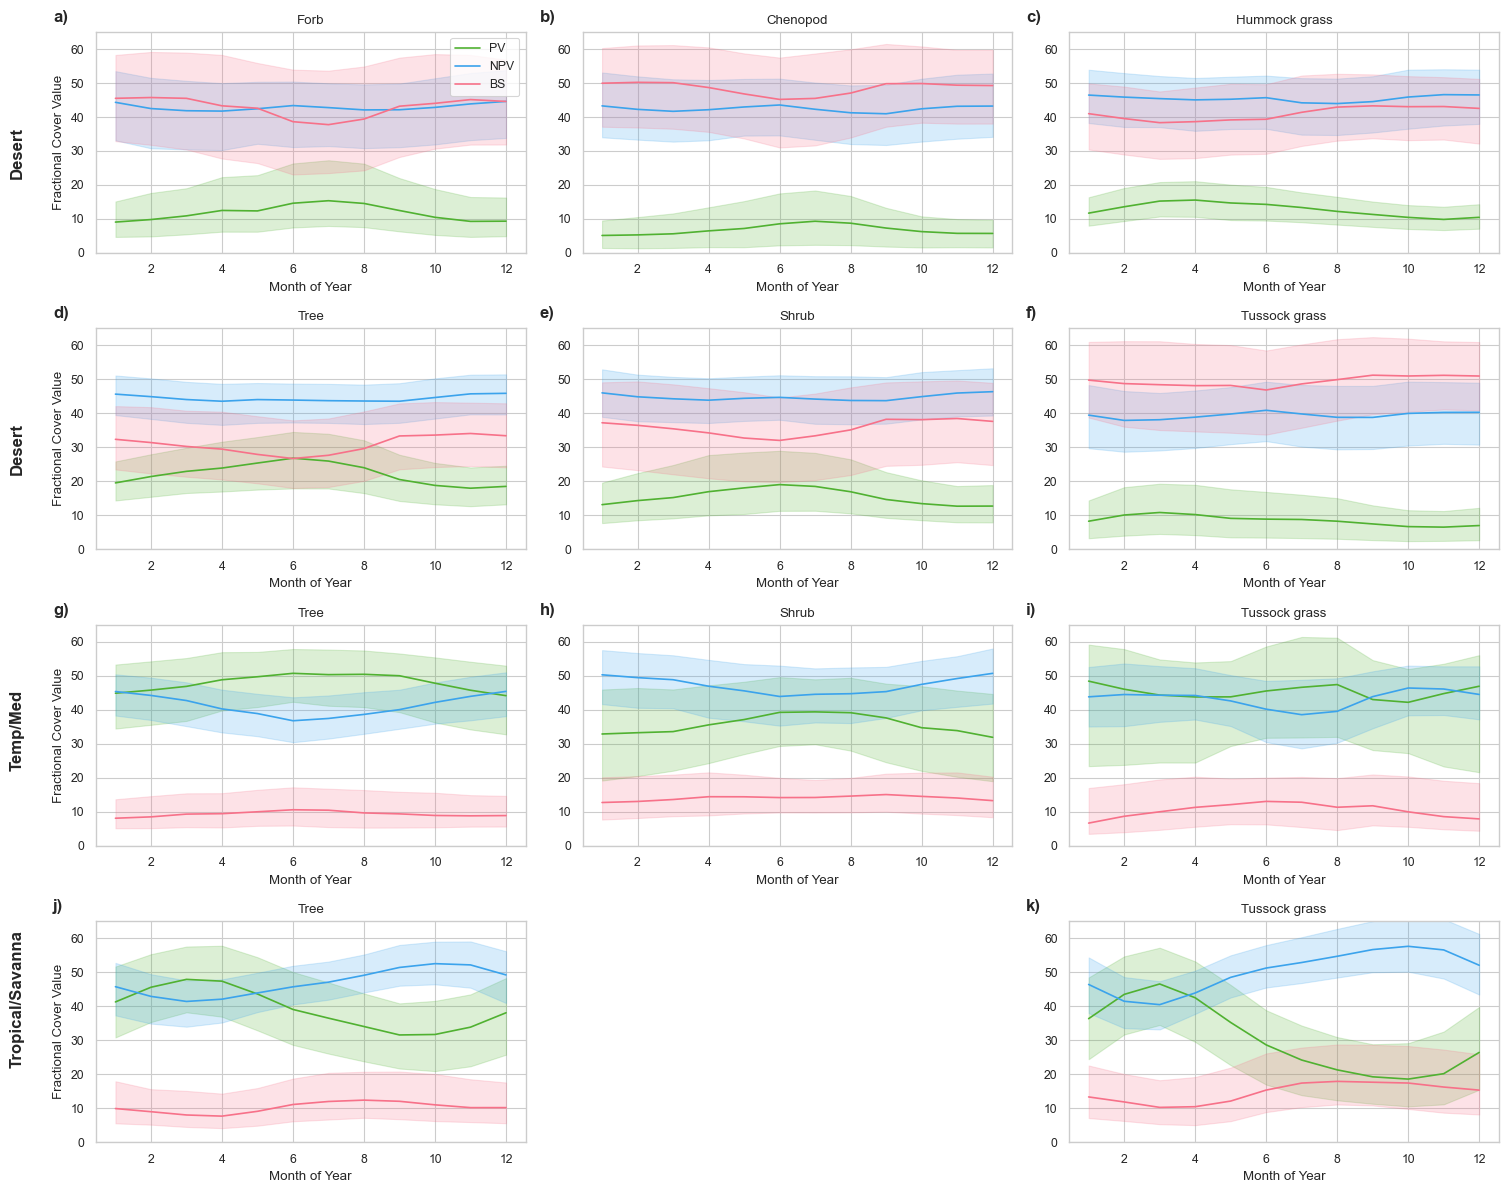

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']


for i, ax in enumerate(axes.flat):
    
    # Skip at the bottom middle grid
    if i == 10:
        ax.axis('off') 
        continue
    
    if i == 11:
        chosen_group = ordered_veg_list[10] # Since there will be a skip on the 11th cell, move the 11th veg type to the 12th grid 
    else:
        chosen_group = ordered_veg_list[i]
        
    super_group_folder_name = '_'.join(chosen_group.split('/')) 
    
    print(f'{super_group_folder_name}')
    
    # Combine the training and set set 
    training = pd.read_csv(f'{results_dir}/{super_group_folder_name}/Training/{super_group_folder_name}_Training_Set.csv', parse_dates = ['time'])
    test = pd.read_csv(f'{results_dir}/{super_group_folder_name}/Training/{super_group_folder_name}_Test_Set.csv', parse_dates = ['time'])
    full_data_set = pd.concat([training, test])
    full_data_set['month'] = full_data_set['time'].dt.month
    
    # Plot the data
    full_data_set[['pv_filter', 'npv_filter', 'bs_filter', 'month']].groupby('month').median().plot(ax = ax, **{'color' : color_palette,},
                                                                                                 label = ['PV', 'NPV', 'BS'])
    
    lower = full_data_set[['pv_filter', 'npv_filter', 'bs_filter', 'month']].groupby('month').quantile(0.25)
    upper = full_data_set[['pv_filter', 'npv_filter', 'bs_filter', 'month']].groupby('month').quantile(0.75)
    
    ax.fill_between(lower.index, lower['pv_filter'], upper['pv_filter'], color=color_palette[0], alpha=0.2, label='0.25%-0.75% Quantiles')
    ax.fill_between(lower.index, lower['npv_filter'], upper['npv_filter'], color=color_palette[1], alpha=0.2)
    ax.fill_between(lower.index, lower['bs_filter'], upper['bs_filter'], color=color_palette[2], alpha=0.2)
    
    
    # Set ylims
    ax.set_ylim((0,65))
    
    # Annotation
    ax.text(-0.1, 1.1, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    # Title
    veg_name = ' '.join(chosen_group.split(" ")[1].split('.'))
    if veg_name == 'Tree Palm':
        veg_name = 'Tree'
    ax.title.set_text(f'{veg_name}')
    
    # Axis lables 
    if i % 3 == 0:
        ax.set_ylabel(f'Fractional Cover Value')
        ax.text(-0.2, 0.35, chosen_group.split(" ")[0], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', rotation=90)
    else:
        ax.set_ylabel(' ')
    ax.set_xlabel('Month of Year')
    
    # Remove Legend
    if i != 0:
        ax.get_legend().remove()
        
    elif i == 0:
        handles = ax.get_legend_handles_labels()[0]
        new_labels = ['PV', 'NPV', 'BS']
        ax.legend(handles, new_labels)
        
plt.tight_layout()
fig.savefig(f'{plots_dir}/Total_Seasonalities.png', bbox_inches="tight")